In [4]:
%load_ext autoreload
%autoreload 2
from tools import fix_figure, savefig, despine, set_style
set_style('notebook')
from method import IV
import nest
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns

from exana.statistics.tools import ccg_significance
from exana.statistics.plot import plot_xcorr
from exana.stimulus.plot import plot_psth
# from exana.statistics import plot_xcorr
import copy
# from IPython.display import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Slow synapse parameters

In [5]:
# more noise
# longer EPSP rise time 4 ms, duration 20 ms
par = {
    'msd'            : 1234, # Master seed
    'num_threads'    : 4,
    'N_neurons'      : 3,
    'res'            : 0.1, # Temporal resolution for simulation Delta t in ms
    'delay'          : 1.5, # Synaptic delay in ms
    'rate_p'         : 1000., # external poisson rate in Hz
    'J_p'            : .3,
    'gauss_mean'     : .1,
    'gauss_std'      : 1.1,
    # Neuron parameters
    't_ref'          : 2.0, # Duration of refractory period in ms
    'V_m'            : 0.0, # Membrane potential, initial condition in mV
    'E_L'            : 0.0, # Leak reversal potential in mV
    'V_reset'        : 0.0, # Reset potential of the membrane in mV
    'tau_m'          : 20.0, # Membrane timeconstant in ms
    'C_m'            : 1.0, # Capacity of the membrane in pF
    'V_th'           : 20.0, # Spike threshold in mV
    'tau_syn_ex'     : 1., # Time constants of the excitatory synaptic exponential function in ms
    'tau_syn_in'     : 1., # Time constants of the inhibitory synaptic exponential function in ms
    # Connection parameters
    'J_AB'           : 0., # mV
    'J_AC'           : 0,
    'J_BC'           : .0002,
    'J_BA'           : 0,
    'J_CA'           : 0,
    'J_CB'           : 0,
    'C'              : 10000, # indegree
    # Stimulation parameters
    'stim_amp_A'      : 10.0, # pA
    'stim_amp_B'      : 10.0, # pA
    'stim_period'     : 100.0, # ms
    'stim_max_period' : 150, # only applies to poisson
    'stim_duration'   : 2.0, # ms
    'stim_N'          : 30000,
    'stim_dist'       : 'poisson'
}

In [6]:
def poisson_clipped(N, period, low, high):
    poisson = []
    while len(poisson) < N:
        p = - np.log(1 - np.random.uniform(0, 1)) * period
        if p >= low and p <= high:
            poisson.append(p)
    stim_times = [poisson[0]]
    for idx, isi in enumerate(poisson[1:]):
        stim_times.append(stim_times[idx] + isi)
    return np.array(stim_times).round()


def simulate(par, **kwargs):
    par = copy.deepcopy(par)
    if kwargs:
        assert all(k in par for k in kwargs.keys())
        par.update(kwargs)
    if par['stim_dist'] is None:
        stim_times = np.linspace(par['stim_period'], 
                                 par['stim_N'] * par['stim_period'],
                                 par['stim_N'])
    elif par['stim_dist'] == 'poisson':
        stim_times = poisson_clipped(
                N=par['stim_N'], period=par['stim_period'],
                low=par['stim_period'], high=par['stim_max_period'])
    print('simulating ', stim_times[-1])
    print('stimulating ', len(stim_times))
    # Set kernel
    nest.ResetKernel()
    nest.SetKernelStatus({"local_num_threads": par['num_threads']})
    N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]
    pyrngs = [np.random.RandomState(s) for s in range(par['msd'], par['msd'] + N_vp)]
    nest.SetKernelStatus({'grng_seed' : par['msd'] + N_vp})
    nest.SetKernelStatus({'rng_seeds' : range(par['msd'] + N_vp + 1, par['msd'] + 2 * N_vp + 1)})
    nest.SetStatus([0], [{"resolution": par['res']}])

    # Make the nodes
    nodes = nest.Create('iaf_psc_alpha', par['N_neurons'])
    keys = ['t_ref', 'V_m', 'E_L', 'V_reset', 'tau_m', 'C_m', 'V_th', 'tau_syn_ex', 'tau_syn_in']
    nest.SetStatus(nodes, [{k: par[k] for k in keys}])

    # Connect nodes
    nn = {
        'A': tuple([nodes[0]]),
        'B': tuple([nodes[1]]),
        'C': tuple([nodes[2]])
    }
    for key in ['J_AB', 'J_AC', 'J_BA', 'J_BC', 'J_CA', 'J_CB']:
        j = par.get(key)
        if j != 0 and j is not None:
            print('connecting ', key, j)
            s, r = nn[key[-2]], nn[key[-1]]
            conn_dict = {'rule': 'fixed_indegree', 'indegree': par['C']}
            nest.Connect(s, r, conn_dict,
                         {"weight": j, "delay": par['delay']})

    # Set background drive
    background = nest.Create("poisson_generator", 1,
                              params={"rate": par['rate_p']})
    nest.Connect(background, nodes, 
                 {'rule': 'fixed_indegree', 'indegree': 1},
                 {"weight": par['J_p'], "delay": par['res']})

    # Set channel noise
    channelnoise = nest.Create("noise_generator", 1,
                              params={"mean": par['gauss_mean'],
                                      'std': par['gauss_std']})
    nest.Connect(channelnoise, nodes)

    # Connect spike detector
    spks = nest.Create("spike_detector", 1,
                         params=[{"label": "Exc", "to_file": False}])
    # connect using all_to_all: all recorded excitatory neurons to one detector
    nest.Connect(nodes, spks)

    # Simulate one period without stimulation
    nest.Simulate(stim_times[0])

    # Set dc stimulation
    stims = []
    for n, a in enumerate([par['stim_amp_A'], par['stim_amp_B']]):
        stim = nest.Create(
            "dc_generator",
            params={'amplitude': a,
                    'start': 0.,
                    'stop': par['stim_duration']})
        nest.Connect(stim, tuple([nodes[n]]))
        stims.append(stim)

    # Run multiple trials
    for s in np.diff(stim_times):
        for stim in stims:
            nest.SetStatus(stim, {'origin': nest.GetKernelStatus()['time']})
        nest.Simulate(s)
    nest.Simulate(np.min(np.diff(stim_times)))

    # Organize data
    conns = nest.GetConnections(source=nodes, target=nodes)
    df = pd.DataFrame(nest.GetStatus(spks, 'events')[0])
    names = ['A', 'B', 'C']
    spiketrains = [{'times': np.array(attr['times']),
                    'sender': sndr,
                    'name': names[sndr - 1]}
                   for sndr, attr in df.groupby('senders')]
    data = {
        'spiketrains': spiketrains,
        'epoch': {'times': stim_times, 
                  'durations': [par['stim_duration']] * len(stim_times)},
        'connections': list(nest.GetStatus(conns, ('weight', 'source', 'target'))),
        'status': nest.GetKernelStatus(),
        'params': par
    }
    return data

In [7]:
# dataa = simulate(par, stim_N=30000
# np.savez('method_triple', data=dataa)
dataa = np.load('method_triple.npz')['data'][()]

In [8]:
winsize = 4
latency = 4
res = []
N_trials = np.arange(100, 31000, 1000)
for N in N_trials:
    ws = [[], []]
    for n in [0,1]:
        iv = IV(dataa['spiketrains'][n]['times'], 
                dataa['spiketrains'][2]['times'],
                dataa['epoch']['times'][:N],
                winsize=winsize, latency=latency)
        ws[n].append(iv.wald)
    res.append(ws)
res = np.array(res)

In [9]:
set_style('article')
t_stop = dataa['status']['time']
spiketrains = [s['times'] for s in dataa['spiketrains']]
names = ['A', 'B', 'C']
colors = sns.color_palette()

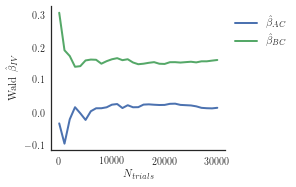

In [10]:
set_style('article', w=0.485)
plt.plot(N_trials, res[:,0], label='$\\hat\\beta_{AC}$', color=colors[0])
plt.plot(N_trials, res[:,1], label='$\\hat\\beta_{BC}$', color=colors[1])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
savefig(plt.gcf(), 'wald_triple')

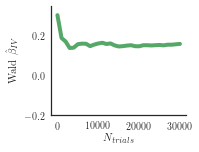

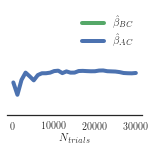

In [16]:
set_style('article', w=.485, h=1)
ylim = [-0.2, 0.35]
plt.figure()
plt.plot(N_trials, res[:,1], c=colors[1], lw=4)
plt.ylabel('Wald $\\hat\\beta_{IV}$')
plt.xlabel('$N_{trials}$')
plt.ylim(ylim)
despine()
savefig(plt.gcf(), 'wald_BC', bbox_inches='tight')

plt.figure()
bc = plt.Line2D((0,1),(0,1), color=colors[1], lw=4)
ac, = plt.plot(N_trials, res[:,0], c=colors[0], lw=4)
plt.legend([bc, ac], ['$\\hat\\beta_{BC}$', '$\\hat\\beta_{AC}$'], 
           loc=0)
plt.xlabel('$N_{trials}$')
plt.ylim(ylim)
despine(yticks=False, left=True)
# plt.setp(plt.gca().get_yticklabels(), visible=False)
# fix_figure()
savefig(plt.gcf(), 'wald_AC', bbox_inches='tight')

['serif']
['serif']


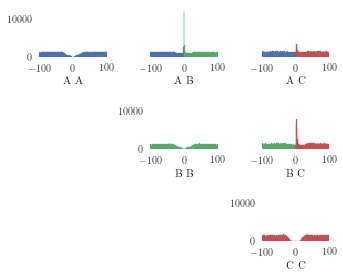

In [7]:
set_style('article', w=0.985, h=2)
plot_xcorr(spiketrains, colors=colors, time_limit=100, binsize=1, names=names,
           xticksvisible=True, yticksvisible=False, density=False);
sns.despine(bottom=True, left=True)
fig = plt.gcf()

savefig(fig, 'xcorr')

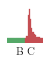

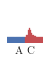

In [13]:
set_style('article', w=.242, h=.25)

time_limit = 15
binsize = 1
ylim = [0, 8500]


for idx, sl in enumerate([slice(1,3), slice(0,3,2)]):
    pcausal, pfast, bins, cch, cch_s = ccg_significance(*spiketrains[sl], binsize, time_limit, 
                                            hollow_fraction=.6, width=10)
    
    _, bins = plot_xcorr(spiketrains[sl], colors=colors[sl], time_limit=time_limit, 
                            binsize=binsize, acorr=False, ylim=ylim, density=False,
                            names=names[sl]);
    ax = plt.gca()
    mask = (bins >= 4) & (bins <= 6)
    m = np.max(cch[mask])
    pmin = pcausal[cch == m]
    trans_prob = sum(cch[mask] - cch_s[mask]) / len(spiketrains[sl][0])
#     plt.plot([bins[pcausal==pmin][0], bins[pcausal==pmin][0]], 
#              [0, m], ls='--', c='k')
#     plt.annotate('p$_{{fast}}$ = {:.2e}'.format(pfast[cch == m][0]), 
#                  [bins[pcausal == pmin][0], ylim[1]])
#     plt.annotate('p$_{{diff}}$ = {:.2e}'.format(pcausal[cch == m][0]), 
#                  [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.05])
#     plt.annotate('p$_{{trans}}$ = {:.2e}'.format(trans_prob), 
#                  [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.1])
    ax.set_aspect(time_limit * 2 / ylim[1])
    ax.set_position([0, 0, 1, 1])
    despine(all_sides=True, xticks=False, yticks=False)
#     if idx == 1:
#         plt.setp(ax.get_yticklabels(), visible=False)
    savefig(plt.gcf(), 'xcorr_highres_{}{}'.format(*names[sl]), bbox_inches='tight')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


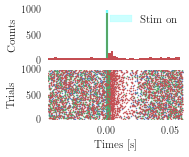

In [14]:
from exana.stimulus import plot_psth
import neo
set_style('article', w=.485)
N_trials = 1000
t_stop = dataa['status']['time']
spiketrains_neo = [neo.SpikeTrain(times=np.array(sptr['times'])*pq.ms, 
                              t_start=0*pq.ms, t_stop=t_stop*pq.ms, name=sptr['name'])
               for sptr in dataa['spiketrains']]
epoch = neo.Epoch(times=dataa['epoch']['times'][:N_trials] * pq.ms, 
                  durations=dataa['epoch']['durations'][:N_trials] * pq.ms)

fig, axs = plt.subplots(2,1, sharex=True)
for n, sptr in enumerate(spiketrains_neo):
    plot_psth(spike_train=sptr, epoch=epoch, xlim=[-.045, .06] * pq.s, axs=axs, hist_binsize=2*pq.ms,
              color=colors[n], stim_color='cyan', hist_alpha=1., hist_edgecolor=None, 
              hist_ylabel='Counts', rast_size=1);
sns.despine(bottom=True, left=True)
fig = plt.gcf()
ax_t = fig.axes[-1]
ax_t.set_yticks([0, 500, 1000])
savefig(fig, 'raster', bbox_inches='tight')